## Plotting with CmdStan.jl outputs

In [1]:
using ArviZ

# use fancy HTML for xarray.Dataset if available
try
    ArviZ.xarray.set_options(display_style = "html")
catch
    nothing
end

# ArviZ ships with style sheets!
ArviZ.use_style("arviz-darkgrid")

ArviZ is designed to work well with high dimensional, labelled data.
Consider the [eight schools model](https://statmodeling.stat.columbia.edu/2014/01/21/everything-need-know-bayesian-statistics-learned-eight-schools/), which roughly tries to measure the effectiveness of SAT classes at eight different schools.
To show off ArviZ's labelling, I give the schools the names of [a different eight schools](https://en.wikipedia.org/wiki/Eight_Schools_Association).

This model is small enough to write down, is hierarchical, and uses labelling.
Additionally, a centered parameterization causes [divergences](https://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html) (which are interesting for illustration).

First we create our data and set some sampling parameters.

In [2]:
J = 8
y = [28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]
σ = [15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]
schools = [
    "Choate",
    "Deerfield",
    "Phillips Andover",
    "Phillips Exeter",
    "Hotchkiss",
    "Lawrenceville",
    "St. Paul's",
    "Mt. Hermon"
]

nwarmup, nsamples, nchains = 1000, 1000, 4;

CmdStan.jl and StanSample.jl can produce `MCMCChains.Chains` outputs, and we can easily plot these chains.

Here is the centered eight schools model:

In [3]:
using CmdStan, MCMCChains

schools_code = """
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}

generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

schools_dat = Dict("J" => J, "y" => y, "sigma" => σ)
stan_model = Stanmodel(
    model = schools_code,
    nchains = nchains,
    num_warmup = nwarmup,
    num_samples = nsamples;
    output_format = :mcmcchains,
    random = CmdStan.Random(8675309),
)
_, stan_chns, _ = stan(stan_model, schools_dat, summary = false);


File /Users/saxen/projects/ArviZ.jl/examples/tmp/noname.stan will be updated.



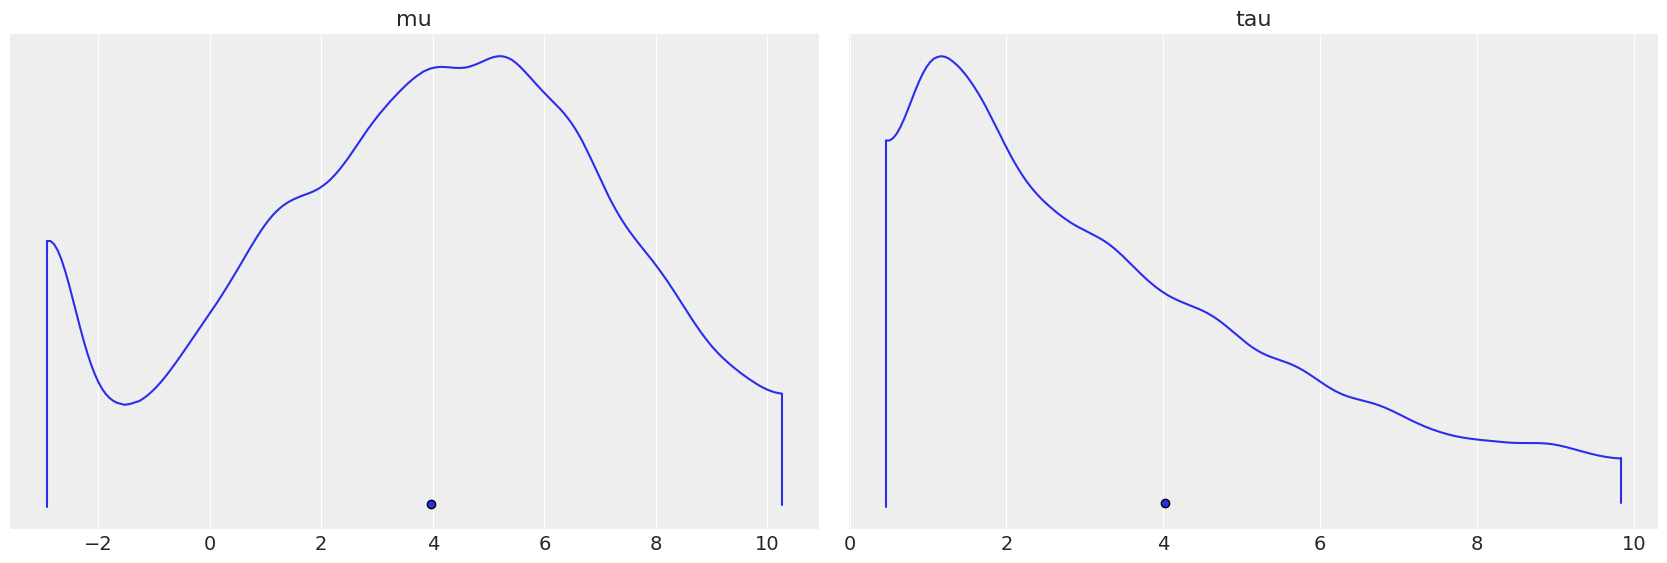

In [4]:
plot_density(convert_to_inference_data(stan_chns); var_names=["mu", "tau"]);

Again, converting to `InferenceData`, we can get much richer labelling and mixing of data.
Note that we're using the same `from_cmdstan` function used by ArviZ to process cmdstan output files, but through the power of dispatch in Julia, if we pass a `Chains` object, it instead uses ArviZ.jl's overloads, which forward to `from_mcmcchains`.

In [5]:
idata = from_cmdstan(
    stan_chns;
    posterior_predictive = "y_hat",
    observed_data = Dict("y" => schools_dat["y"]),
    log_likelihood = "log_lik",
    coords = Dict("school" => schools),
    dims = Dict(
        "y" => ["school"],
        "sigma" => ["school"],
        "theta" => ["school"],
        "log_lik" => ["school"],
        "y_hat" => ["school"],
    ),
)

InferenceData with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Here is a plot showing where the Hamiltonian sampler had divergences:

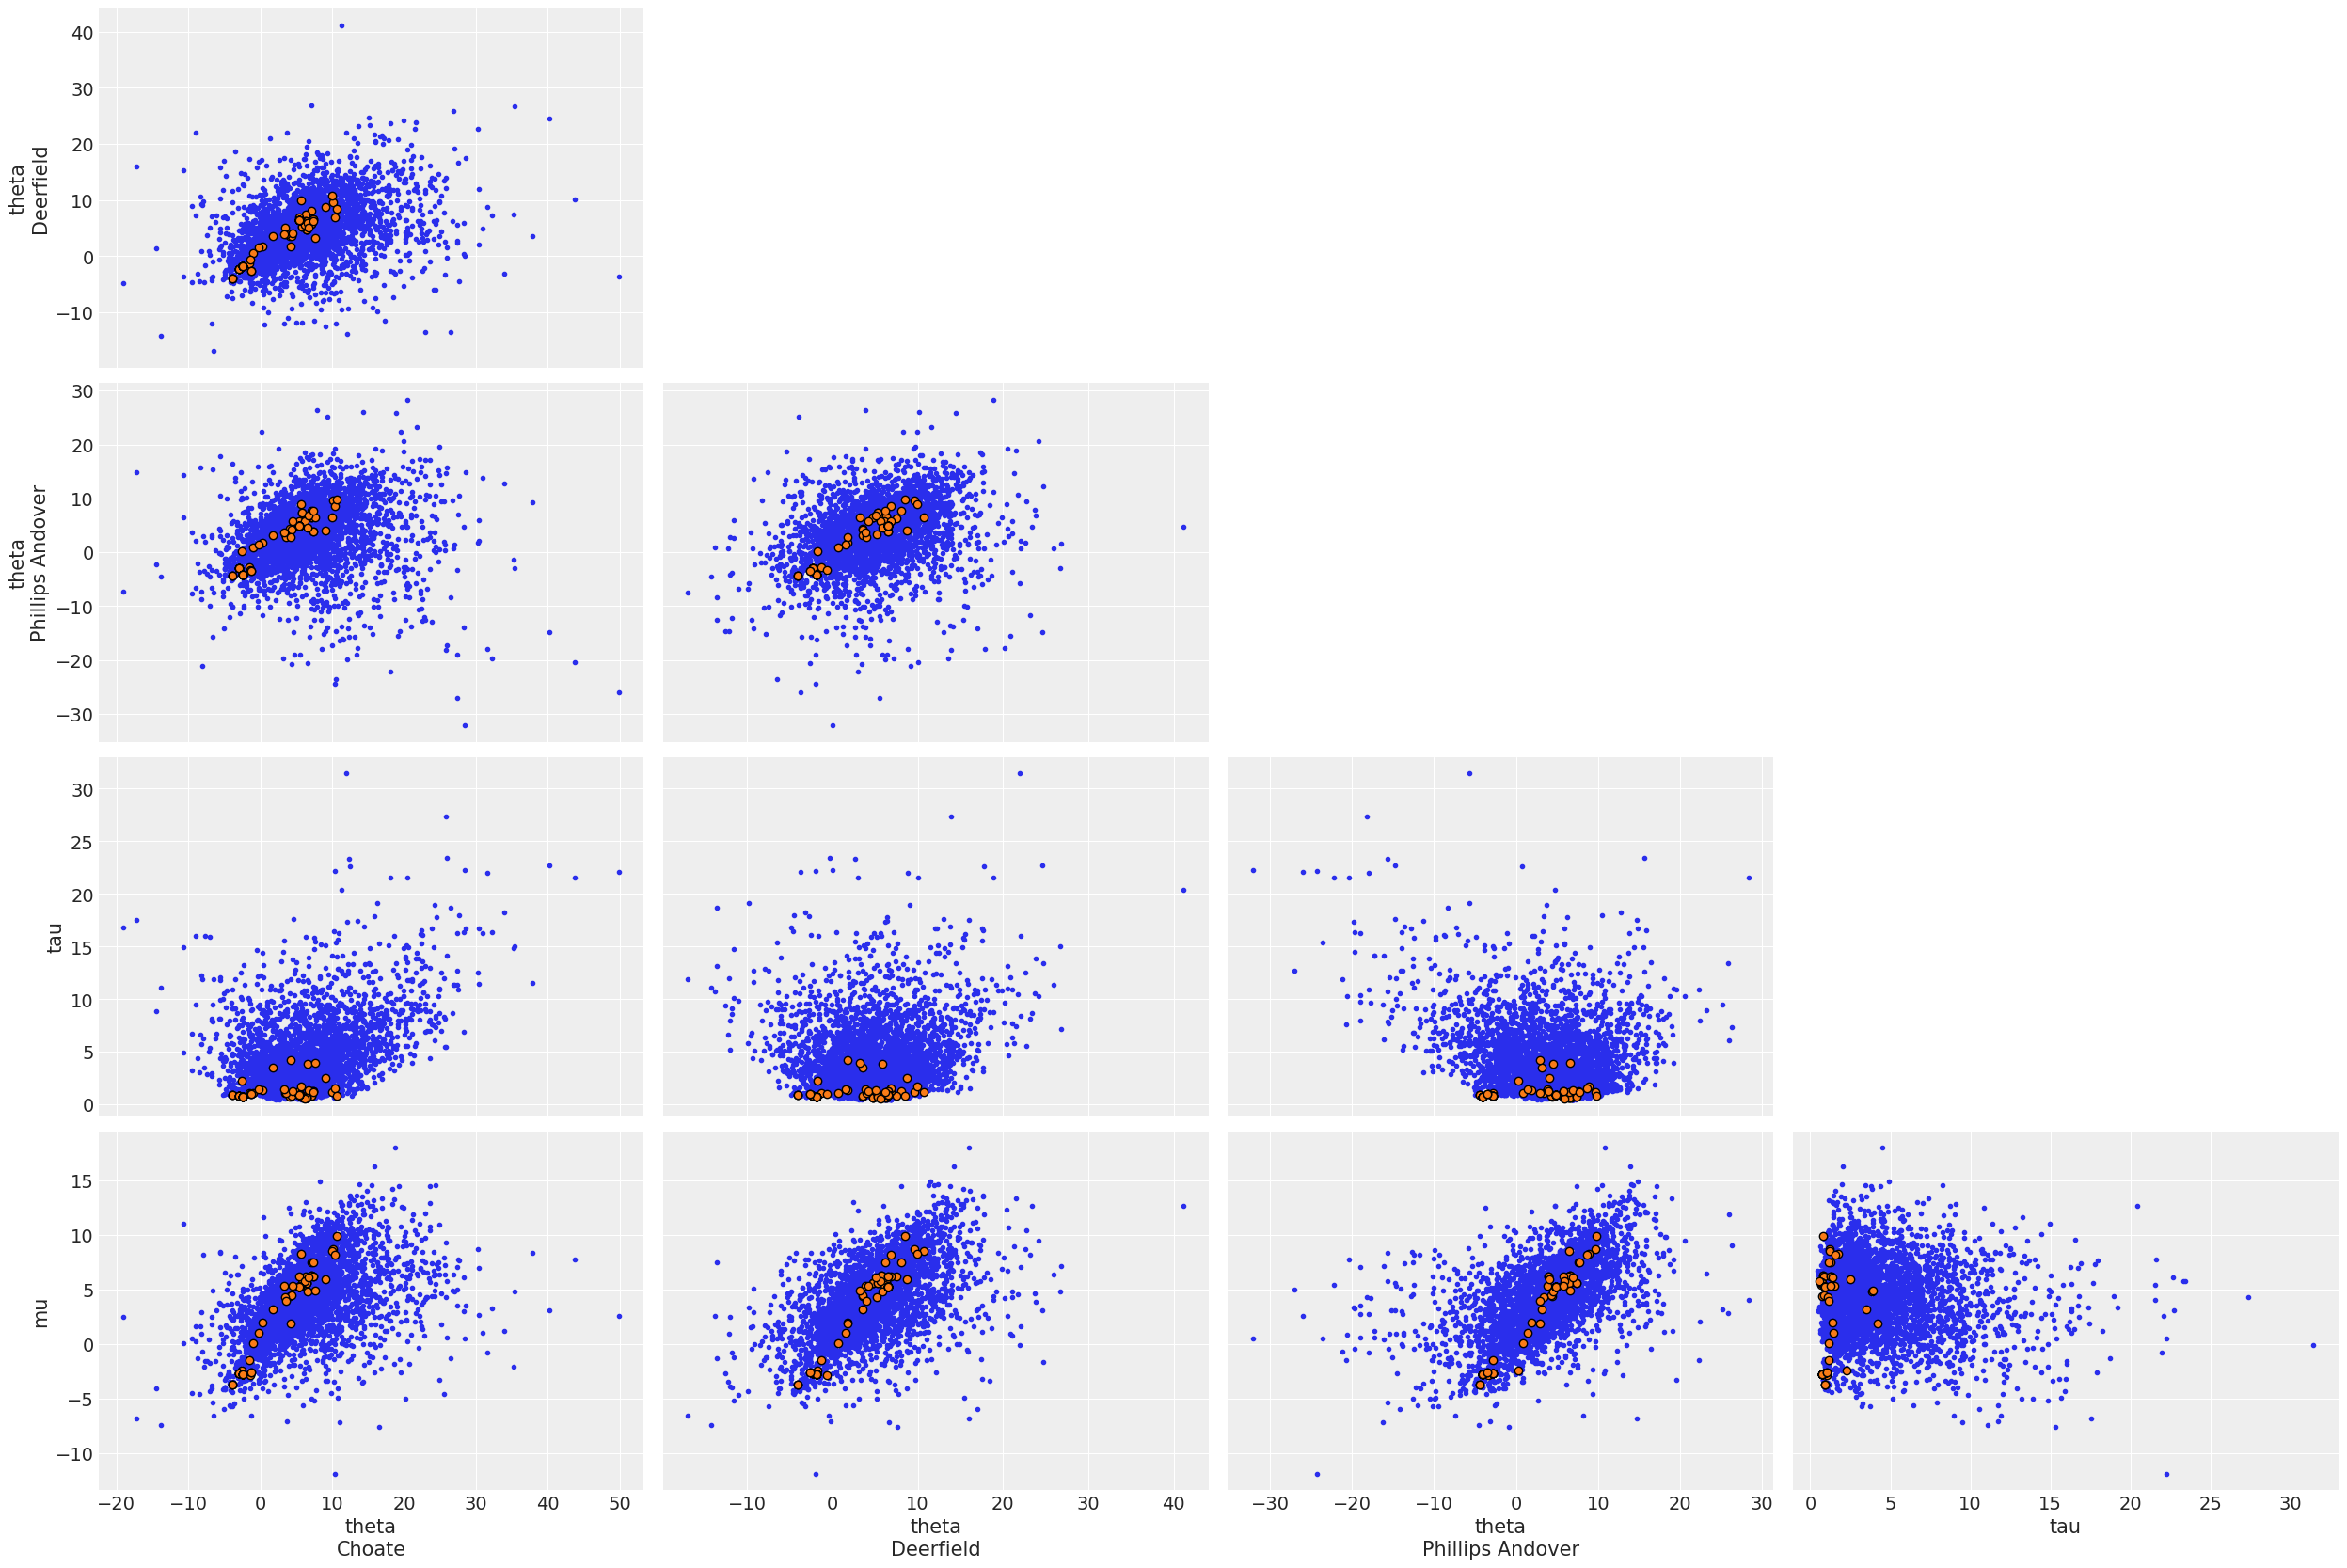

In [6]:
plot_pair(
    idata;
    coords = Dict("school" => ["Choate", "Deerfield", "Phillips Andover"]),
    divergences = true,
);

## Environment

In [7]:
using Pkg
Pkg.status()

    Status `~/projects/ArviZ.jl/examples/Project.toml`
  [131c737c] ArviZ v0.2.5 #master (https://github.com/arviz-devs/ArviZ.jl.git)
  [593b3428] CmdStan v6.0.2
  [31c24e10] Distributions v0.21.12
  [7073ff75] IJulia v1.21.1
  [c7f686f2] MCMCChains v1.0.2
  [d9ec5142] NamedTupleTools v0.12.1
  [8ce77f84] Soss v0.10.0
  [fce5fe82] Turing v0.8.2


In [8]:
versioninfo()

Julia Version 1.3.1
Commit 2d5741174c (2019-12-30 21:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.6.0)
  CPU: Intel(R) Core(TM) i7-4870HQ CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, haswell)
Environment:
  JULIA_CMDSTAN_HOME = /Users/saxen/projects/cmdstan-2.18.0


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*